# Implementing a Random Forest Classifier
Simple Random Forest implementation for redhat dataset

In [1]:
# A bit of setup

import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

# Prepare Data


In [2]:
train_df = pd.read_csv('act_train.csv')
people_df = pd.read_csv('people.csv')
merged_df = pd.merge(train_df, people_df, on='people_id')
test_df = pd.read_csv('act_test.csv')

merged_col = merged_df.columns
summary_merged_df = [len(merged_df[col].unique()) for col in merged_col]
print "load complete"

load complete


In [3]:
test_col = test_df.columns
summary_test_df = [len(test_df[col].unique()) for col in test_col]

setA = set(train_df['char_8'])
setB = set(test_df['char_8'])
setA.union(setB) - setA.intersection(setB)

set()

## Convert attributes
- Categorical : type ## / NaN
- Boolean (True False)

In [4]:
#merged_df['char_1_x'].replace({'type':'', ' ':'', np.nan : '0'}, regex = True).astype('int')
#Columns to be converted
merged_df = pd.merge(train_df, people_df, on='people_id')
parsed_col = set(merged_col) - set(['people_id','activity_id','date_x','date_y'])
for col in parsed_col:
    print (col)
    if(type(merged_df[col][0]) is np.bool_):
        print('- is boolean')
        merged_df[col] = merged_df[col].astype('int64')
    elif (type(merged_df[col][0]) is np.int64 or type(merged_df[col][0]) is np.long):
        print('- is integer')
        merged_df[col] = merged_df[col].astype('int64')
    else:
        print('- is type/category')
        merged_df[col] = merged_df[col].replace({'group': '', 'type':'', ' ':'', np.nan : '0'}, regex = True).astype('int64')


group_1
- is type/category
char_12
- is boolean
char_33
- is boolean
char_2_y
- is type/category
activity_category
- is type/category
char_38
- is integer
char_1_y
- is type/category
char_8_y
- is type/category
char_19
- is boolean
char_18
- is boolean
char_17
- is boolean
char_8_x
- is type/category
char_15
- is boolean
char_32
- is boolean
char_9_y
- is type/category
char_9_x
- is type/category
char_11
- is boolean
char_1_x
- is type/category
char_3_y
- is type/category
char_3_x
- is type/category
char_6_y
- is type/category
char_5_y
- is type/category
char_31
- is boolean
outcome
- is integer
char_25
- is boolean
char_10_x
- is type/category
char_10_y
- is boolean
char_30
- is boolean
char_2_x
- is type/category
char_35
- is boolean
char_16
- is boolean
char_26
- is boolean
char_27
- is boolean
char_24
- is boolean
char_14
- is boolean
char_22
- is boolean
char_23
- is boolean
char_20
- is boolean
char_5_x
- is type/category
char_4_x
- is type/category
char_13
- is boolean
char_21
-

In [5]:
merged_test_df = pd.merge(test_df, people_df, on='people_id')
merged_test_col = merged_test_df.columns
parsed_test_col = set(merged_test_col) - set(['people_id','activity_id','date_x','date_y'])
for col in parsed_test_col:
    print (col)
    if(type(merged_test_df[col][0]) is np.bool_):
        print('- is boolean')
        merged_test_df[col] = merged_test_df[col].astype('int64')
    elif (type(merged_test_df[col][0]) is np.int64 or type(merged_test_df[col][0]) is np.long):
        print('- is integer')
        merged_test_df[col] = merged_test_df[col].astype('int64')
    else:
        print('- is type/category')
        merged_test_df[col] = merged_test_df[col].replace({'group': '', 'type':'', ' ':'', np.nan : '0'}, regex = True).astype('int64')

group_1
- is type/category
char_12
- is boolean
char_33
- is boolean
char_2_y
- is type/category
activity_category
- is type/category
char_38
- is integer
char_1_y
- is type/category
char_8_y
- is type/category
char_19
- is boolean
char_18
- is boolean
char_17
- is boolean
char_8_x
- is type/category
char_15
- is boolean
char_32
- is boolean
char_9_y
- is type/category
char_9_x
- is type/category
char_11
- is boolean
char_1_x
- is type/category
char_3_y
- is type/category
char_3_x
- is type/category
char_6_y
- is type/category
char_5_y
- is type/category
char_31
- is boolean
char_25
- is boolean
char_10_x
- is type/category
char_10_y
- is boolean
char_30
- is boolean
char_2_x
- is type/category
char_35
- is boolean
char_16
- is boolean
char_26
- is boolean
char_27
- is boolean
char_24
- is boolean
char_14
- is boolean
char_22
- is boolean
char_23
- is boolean
char_20
- is boolean
char_5_x
- is type/category
char_4_x
- is type/category
char_13
- is boolean
char_21
- is boolean
char_28
-

# Load Train and Validation Data
load all data from pre-processed data

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [15]:
tmp = merged_df.drop(['people_id','activity_id','date_x','date_y','outcome'], 1)
x = tmp.values
y = merged_df['outcome'].values
n = len(x)
offset = 0
# n = 500000
X = x[0+offset:n+offset,:]
Y = y[0+offset:n+offset]
print X.shape
print Y.shape
print len(X)

(2197291, 50)
(2197291,)
2197291


# Apply Random Forest


In [16]:
num_folds = 5
num_instances = n
seed = 7
num_trees = 100
max_features = 'auto'

""" Random Forest Classifier with K-Fold, K=5 """
cv = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed) 
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features) 
model.fit(X,Y)

results = cross_validation.cross_val_score(model, X, Y, cv=cv) 
print(results.mean())

0.864219153128


In [24]:
num_folds = 10
num_instances = n
seed = 7
num_trees = 140
max_features = 'auto'

""" Random Forest Classifier with K-Fold, k=10 """
cv = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed) 
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features) 
model.fit(X,Y)

results = cross_validation.cross_val_score(model, X, Y, cv=cv) 
print(results.mean())

KeyboardInterrupt: 

# Learning Curve
To estimate how doing well on the classifer by checking the training score and the cross-validation score.

/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view 

<module 'matplotlib.pyplot' from '/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

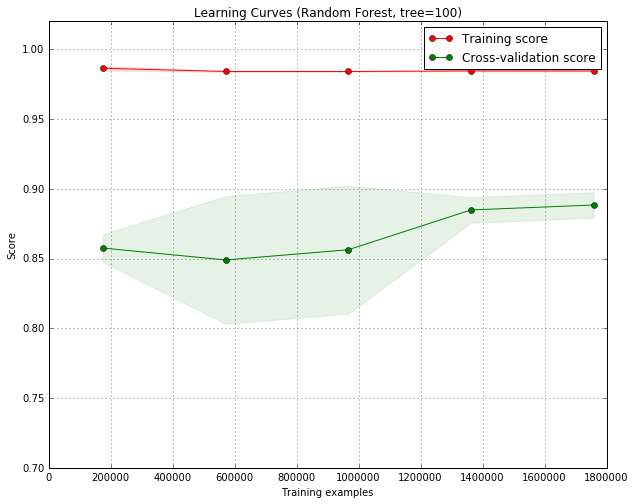

In [17]:
title = "Learning Curves (Random Forest, tree=100)"
plot_learning_curve(model, title, X, Y, (0.7, 1.02), cv=cv, n_jobs=4)

# Predict Test Case
To predict the submission

In [18]:
activity_id = list(merged_test_df.activity_id)
test_dataset = merged_test_df.drop(['people_id','activity_id','date_x','date_y'], 1)
test_mat = np.array(test_dataset, dtype='int')
print test_mat.shape

ans = model.predict(test_mat)
print ans.shape

(498687, 50)
(498687,)


In [19]:
output_df = pd.DataFrame({'activity_id' : activity_id, 'outcome': ans})
output_df.head(5)

,activity_id,outcome
0,act1_249281,0
1,act2_230855,0
2,act1_240724,1
3,act1_83552,1
4,act2_1043301,1


In [20]:
output_df.sort_values(['activity_id','outcome']).to_csv('output_random_forest.csv', index=False)